# Load Packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn import set_config
# set_config(display='diagram')

import warnings
# warnings.filterwarnings('ignore')

# Load Data

> Data Readme
https://

## Load RAW data

In [2]:
# set data source
data_url = 'data/train.csv'

# set index column
index_col = 'PassengerId'

# load data
data = pd.read_csv(data_url, index_col=index_col)
data.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature-Target split

In [3]:
# define the target column in the train dataset
target = 'Survived'

# split columns into X and y
X = data.drop(columns = target).copy()
y = data[target]

# check the shape of the data
print(f'shape of X is \033[94m{X.shape}\033[0m, shape of y is \033[94m{y.shape}\033[0m')

shape of X is (891, 10), shape of y is (891,)


## Missing Values

feature with missing values (3): ['Age', 'Cabin', 'Embarked']


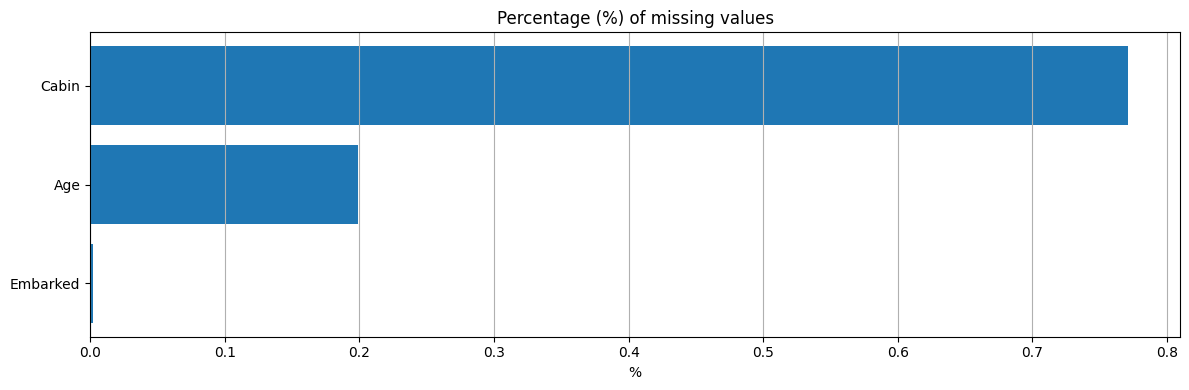

In [13]:
#filter all the features with missing values
feature_null= X.isnull().mean().sort_values(ascending = False)
feature_null=feature_null[feature_null>0]

feature_with_missing_values = feature_null.index.sort_values().to_list()
print(f'feature with missing values (\033[95m{len(feature_with_missing_values)}\
\033[0m): \033[94m{feature_with_missing_values}\033[0m')
# visualize
plt.figure(figsize=(12, 4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_null.index, feature_null.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Percentage (%) of missing values")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Feature Screening

In [17]:
X = data.drop(columns = target).copy()
features_all = X.columns.sort_values().to_list()

columns_to_drop = ['Name', 'Ticket', 'Cabin']
# columns_to_drop = []

X = X.drop(columns=columns_to_drop)

feature_numerical = X.select_dtypes(exclude='object').columns.to_list()

feature_categorical = X.select_dtypes(include='object').columns.to_list()

feature_categorical_Ordinal = []

feature_categorical_OneHot = [key for key in feature_categorical 
                              if key not in feature_categorical_Ordinal]

print(f'All features (\033[95m{len(features_all)}\
\033[0m): \033[94m{features_all}\033[0m')

print(f'Features to drop (\033[91m{len(columns_to_drop)}\
\033[0m): \033[94m{columns_to_drop}\033[0m')

print(f'Categorical cat features (\033[95m{len(feature_categorical)}\
\033[0m): \033[94m{feature_categorical}\033[0m')

print(f'Ordinal cat features (\036[95m{len(feature_categorical_Ordinal)}\
\033[0m): \033[94m{feature_categorical_Ordinal}\033[0m')

print(f'None-ordinal cat features (\033[95m{len(feature_categorical_OneHot)}\
\033[0m): \033[94m{feature_categorical_OneHot}\033[0m')

print(f'Numercial features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

All features (10): ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Ticket']
Features to drop (3): ['Name', 'Ticket', 'Cabin']
Categorical cat features (2): ['Sex', 'Embarked']
Ordinal cat features (0): []
None-ordinal cat features (2): ['Sex', 'Embarked']
Numercial features (5): ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Data Exploration

## Numerical Features

### Overview

Numercial features (5): ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


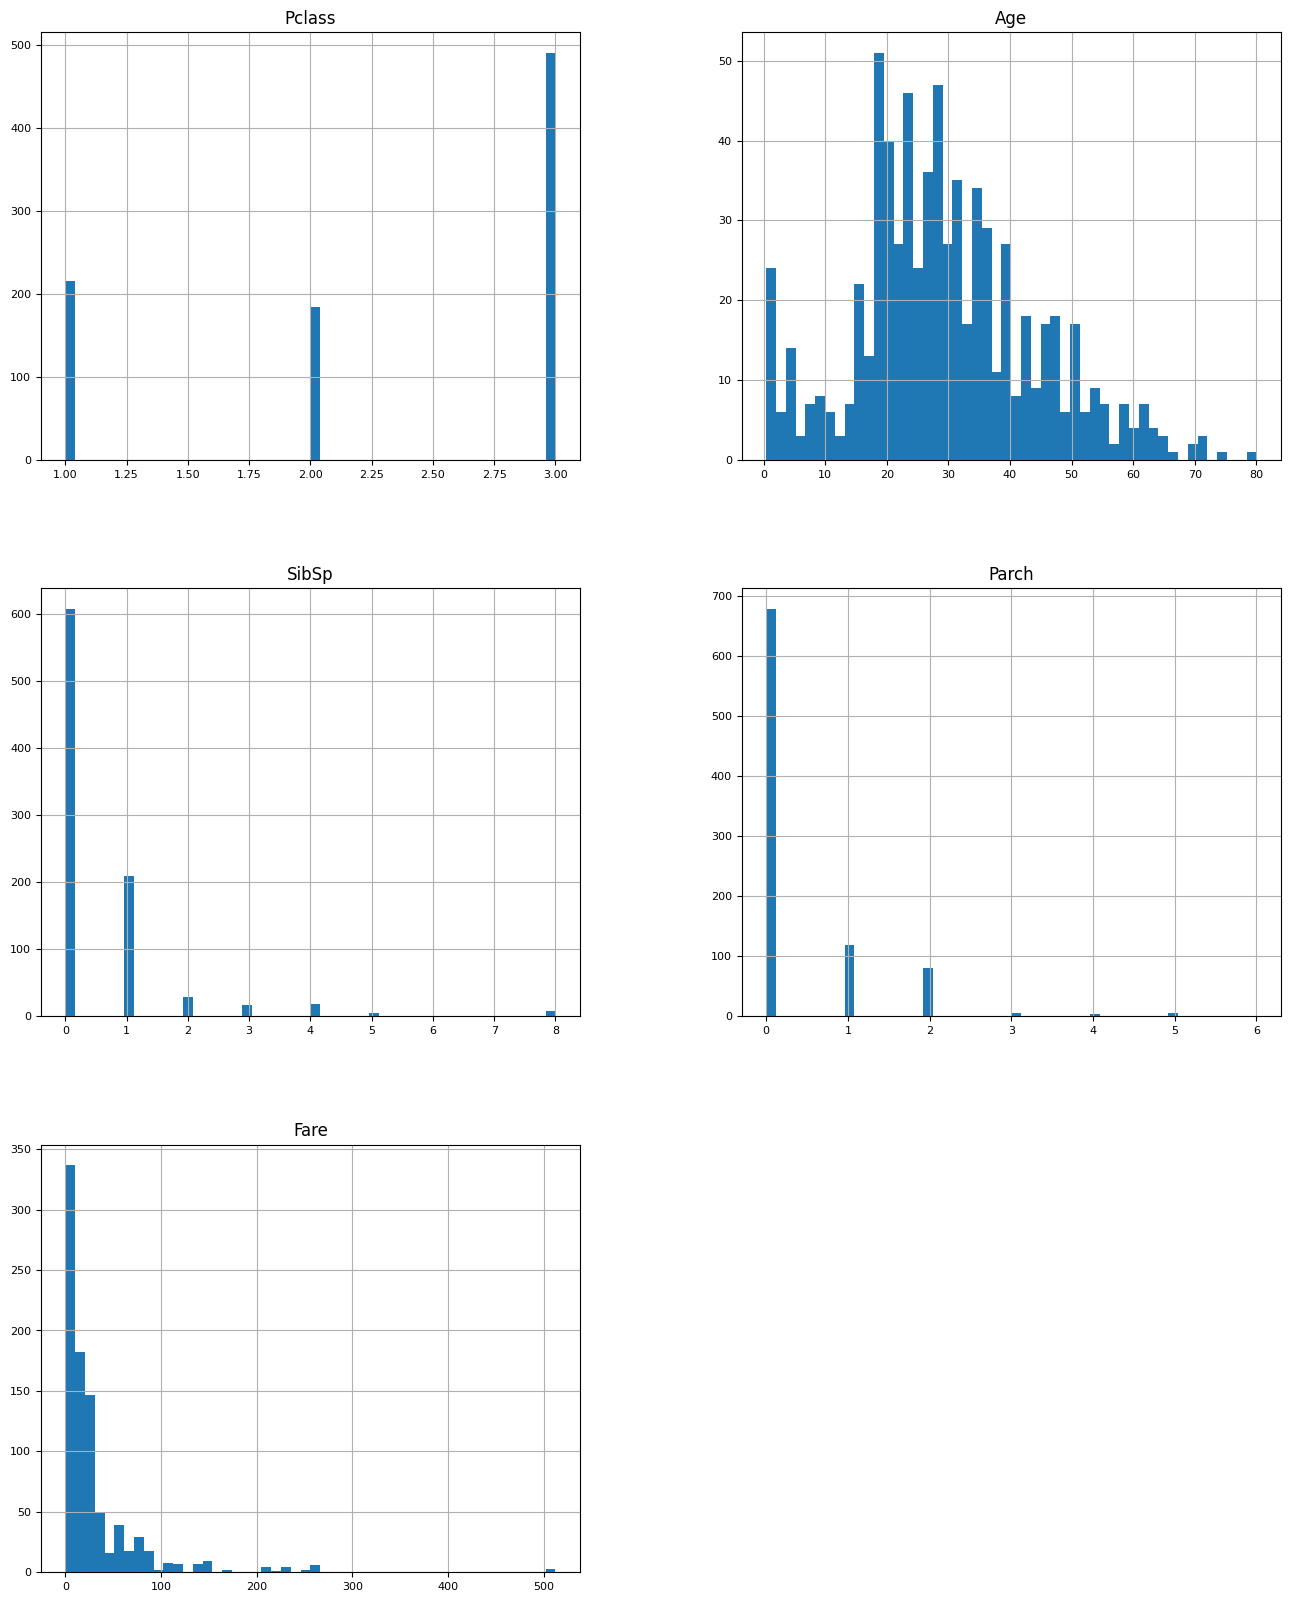

In [57]:
print(f'Numercial features (\033[95m{len(feature_numerical)}\
\033[0m): \033[94m{feature_numerical}\033[0m')

X[feature_numerical].hist(
    figsize=(16, 20), 
    bins=50, 
    xlabelsize=8, 
    ylabelsize=8);

### Corrilations

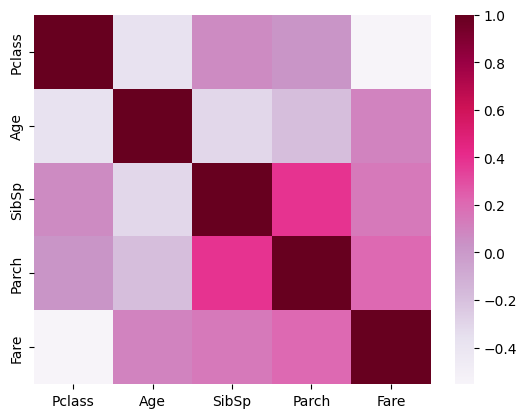

In [20]:
X_num = X[feature_numerical].dropna()

sns.heatmap(X_num.corr(), cmap='PuRd')
pca = PCA()
X_scaled = StandardScaler().fit_transform(X_num)
X_pca = pca.fit_transform(X_scaled)

### Principal components Analysis

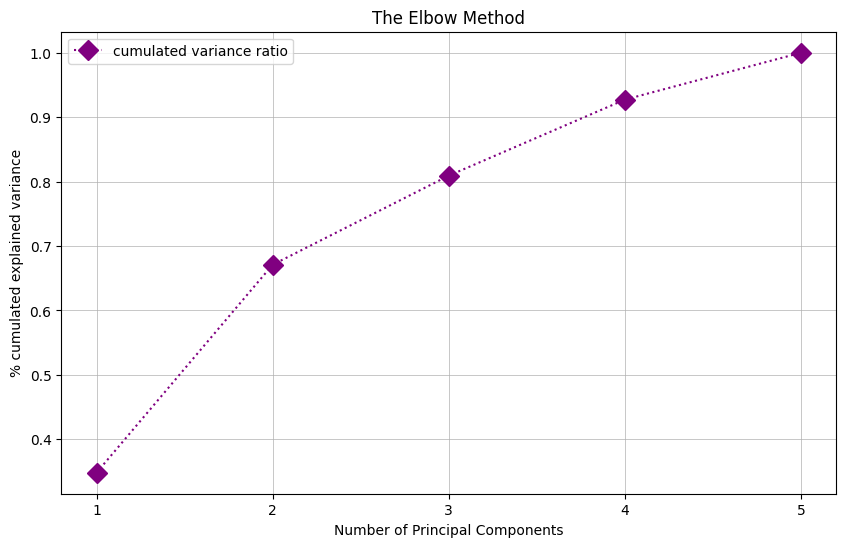

In [27]:
with plt.style.context('seaborn-deep'):
    
    # figsize
    plt.figure(figsize=(10,6))
    
    # getting axes
    ax = plt.gca()
    
    # plotting
    evr_cumulated = np.cumsum(pca.explained_variance_ratio_)
    x_axis_ticks = np.arange(1,evr_cumulated.shape[0]+1)
    ax.plot(x_axis_ticks,evr_cumulated,label="cumulated variance ratio",
            color="purple",linestyle=":",marker="D",markersize=10)
    
    
    # customizing
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('% cumulated explained variance')
    ax.legend(loc="upper left")
    ax.set_title('The Elbow Method')
    ax.set_xticks(x_axis_ticks)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

## Catigorical Features

### Overview

Categorical cat features (2): ['Sex', 'Embarked']


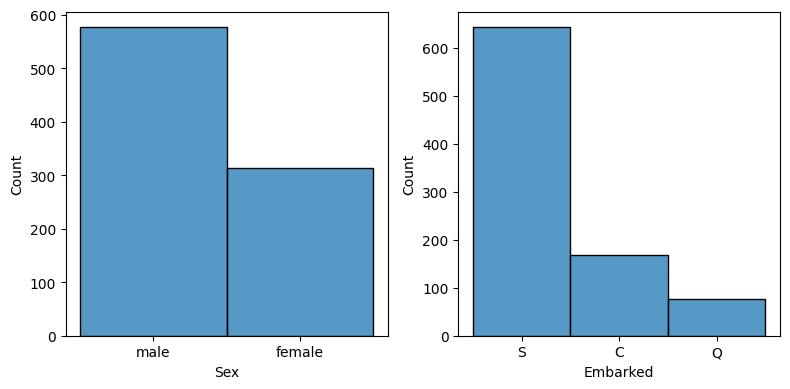

In [50]:
plot_list=feature_categorical

print(f'Categorical cat features (\033[95m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

num_cols = 2  # Number of columns in the grid

num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

# Plot each categorical feature
for i, feature in enumerate(plot_list):
    ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
    sns.histplot(data=X, x=feature, kde=False, ax=ax)

# Hide unused subplots
if len(plot_list) < num_rows * num_cols:
    for j in range(len(plot_list), num_rows * num_cols):
        axes[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()

### Catigorical Ordinal Features

In [55]:
plot_list = feature_categorical_Ordinal

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

Categorical cat features (0): []


Categorical cat features (2): ['Sex', 'Embarked']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

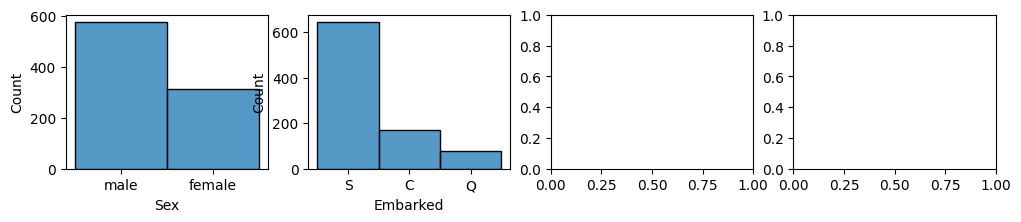

In [52]:
plot_list=feature_categorical_OneHot

print(f'Categorical cat features (\033[94m{len(plot_list)}\
\033[0m): \033[94m{plot_list}\033[0m')

if len(plot_list)>0:
    # Assuming 'X' is your DataFrame
    num_cols = 4  # Number of columns in the grid
    num_rows = (len(plot_list) - 1) // num_cols + 1  # Number of rows in the grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(3*num_cols, 2*num_rows))

    # Plot each categorical feature
    for i, feature in enumerate(plot_list):
        ax = axes[i // num_cols, i % num_cols] if num_rows > 1 else axes[i % num_cols]
        sns.histplot(data=X, x=feature, kde=False, ax=ax)

    # Hide unused subplots
    if len(plot_list) < num_rows * num_cols:
        for j in range(len(plot_list), num_rows * num_cols):
            axes[j // num_cols, j % num_cols].axis('off')

    plt.tight_layout()
    plt.show()

### Catigorical Ordinal Features Mapping

In [ ]:
feat_ordinal_dict = {
    # considers "missing" as the worse category
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
#     "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
#     "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
#     "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
#     "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
#     "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
#     "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex']
#     "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
#     "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
#     "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
#     "PavedDrive": ['missing', 'N', 'P', 'Y'],
#     "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}


ordinal_features = list(feat_ordinal_dict.keys())
ordinal_values = list(feat_ordinal_dict.values())

### Catigorical OneHot Features

/var/folders/cn/4l415qx57kq58d7hp_yy5wk80000gn/T/ipykernel_46302/3587405270.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


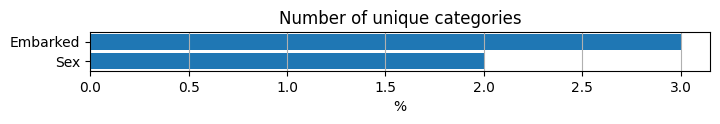

In [53]:
# list the number of categories of each OneHot feature
feature_cat_value_count= X[feature_categorical_OneHot].nunique().sort_values(ascending=False)
feature_cat_value_count=feature_cat_value_count[feature_cat_value_count>0]

# visualize
plt.figure(figsize=(8, feature_cat_value_count.shape[0]/4))
feature_ranks = range(len(feature_null))
bar = plt.barh(feature_cat_value_count.index, feature_cat_value_count.values, label=[str(x) for x in feature_ranks])
plt.gca().invert_yaxis()
plt.xlabel('%')
plt.title("Number of unique categories")
plt.tight_layout()
plt.grid(axis='x')
plt.show()

# Data Preprocessing

In [59]:
#transformer for numerical data
preproc_num = make_pipeline(
    SimpleImputer(strategy='mean'),
    MinMaxScaler()
)

preproc_cat_ordinal = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

preproc_cat_onehot = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(
        drop = 'if_binary',
        sparse_output=False,
        handle_unknown='ignore')
)

preproc_pipeline = make_column_transformer(
    (preproc_num, feature_numerical),
    (preproc_cat_ordinal, feature_categorical_Ordinal),
    (preproc_cat_onehot, feature_categorical_OneHot),
    remainder='passthrough'
)

display(preproc_pipeline)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 []),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [ ]:
preproc_pipeline.fit(X)

# Model

## Custom Loss Function

In [66]:
# EXAMPLE:
def my_rmsle_neg(y_true, y_pred):
    result = -(np.mean((np.log(y_true+1)-np.log(y_pred+1))**2))**0.5
    return result 

from sklearn.metrics import make_scorer
rmsle_neg = make_scorer(my_rmsle_neg)

## Cross Validation

In [61]:
# cv_model = KNeighborsClassifier() #Baseline score: -0.3278517946119624
# cv_model = SVC() #Baseline score: -0.3369862693961591 
# cv_model = SVC(kernel='poly') #Baseline score: -0.2761102147519752 
# cv_model = SVC(kernel='linear') #Baseline score: -0.24822940772121438 
# cv_model = DecisionTreeRegressor(max_depth=6) # Baseline score: -0.20116124161062304
# cv_model = LinearRegression() #Baseline score: -0.17873011648173293 
# cv_model = LogisticRegression(max_iter=2000) #Baseline score: -0.2522674044146145 
cv_model = RandomForestRegressor() # Baseline score: -0.1470104740488312
cv_baseline = make_pipeline(
    preproc_pipeline,
    cv_model
)

cv_result = cross_val_score(
    cv_baseline,
    X, 
    y, 
    cv=5,
#     scoring='',
    n_jobs=-1)
score_baseline=np.mean(cv_result)
print(f'Baseline score: \033[94m{score_baseline}\033[0m \nof {type(cv_model)} model ')

Baseline score: 0.3772297882905267 
of <class 'sklearn.ensemble._forest.RandomForestRegressor'> model 


## Grid/Random Search

### KNN

In [ ]:
knn_pipeline = make_pipeline(
    preproc_pipeline, 
    KNeighborsRegressor()
)

knn_param_grid={
    '__n_neighbors': list(range(1,20,1))
}
knn_search = GridSearchCV(knn_pipeline, 
                      knn_param_grid, 
                      cv=5, 
                      scoring='r2', 
                      n_jobs=-1)
knn_search.fit(X, y)

In [ ]:
knn_best_model = knn_search.best_estimator_
print(knn_search.best_score_)
print(knn_search.best_params_)

### Random Foreast

In [62]:
rf_pipeline = Pipeline([
    ('preprocessing', preproc_pipeline),
    ('modelling', RandomForestRegressor(n_jobs=-1))
])

rf_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked'])])),
                ('modelling', RandomForestRegressor(n_jobs=-1))])

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
# Random search 
rf_random_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions ={
        'modelling__max_depth': randint(15,30),
        'modelling__min_samples_split' : randint(2,5)},
    cv=5,
    n_iter = 10,
    scoring=rmsle_neg,
    n_jobs=-1
    )

rf_random_search.fit(X,y)

rf_tuned_pipe = rf_random_search.best_estimator_
rf_random_search.best_score_

-0.26452167983099206

### SVM